In [1]:
from typing import Annotated
from typing_extensions import TypedDict

In [4]:
from langchain_community.utilities import ArxivAPIWrapper , WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun , WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)

arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [5]:
tools = [arxiv_tool, wikipedia_tool]

In [6]:
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages : Annotated[list, add_messages]

In [7]:
from langgraph.graph import StateGraph,START,END
graph_builder = StateGraph(State)

In [8]:
import os 
import dotenv
groq_api_key = dotenv.get_key('.env', 'GROQ_API_KEY')
langsmith_api_key = dotenv.get_key('.env', 'LANGSMITH_API_KEY')
os.environ['LANGCHAIN_API_KEY'] = langsmith_api_key
os.environ['GROQ_API_KEY'] = groq_api_key
os.environ['LANGCHAIN_TRACING_V2'] = 'true'

In [10]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key =  groq_api_key,model_name = "Llama3-70b-8192")

In [11]:
llm_with_tools = llm.bind_tools(tools)

In [13]:
def chatbot(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [14]:
from langgraph.prebuilt import ToolNode,tools_condition

In [15]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")
tool_node = ToolNode(tools = tools)
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [16]:
graph = graph_builder.compile()

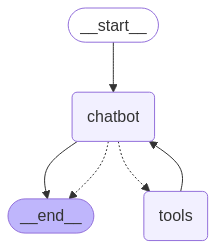

In [17]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
user_input = input("Enter your message: ")
state = {"messages":[("user",user_input)]}
events = graph.stream(state,stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()
        

================================ Human Message =================================

hey , tell me about elon musk
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_yjmh)
 Call ID: call_yjmh
  Args:
    query: Elon Musk
================================= Tool Message =================================
Name: wikipedia

Page: Elon Musk
Summary: Elon Reeve Musk ( EE-lon; born June 28, 1971) is a businessman known for his key roles in Tesla, SpaceX, and Twitter (which he rebranded as X). Since 2025, he has been a senior advisor to United States president Donald Trump and the de facto head of the Department of Governm
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_ma97)
 Call ID: call_ma97
  Args:
    query: Tesla
================================= Tool Message =================================
Name: wikipedia

Page: Tesla, Inc.
Summary: Tesla, Inc. (  TESS-lə or  TEZ-lə) i